# Eye Fixation Prediction in Digital Images

Benjamin Jafek <br>
Dec 14, 2017

## TODO
1. Attach relevant code (how?)
2. How many volunteers were used?
3. Explain why I cleaned the eye fixations the way I did.
4. Explain the CSV that I'm actually using.

# 1. Introduction

# 2. Data

In [13]:
import pandas as pd 
from matplotlib import pyplot as plt
import cv2
import numpy as np

&emsp; The first dataset which I received was from Dr. Steven Luke in the BYU Psychology department. He is very interested in modeling human visual attention, and had just collected eyetracking data on a series of images when I met him. The data consisted of columns including fixation and image information. I discarded columns which described factors either uninteresting or beyond the scope of my project, such as "current_blink" or "saccade peak velocity", retaining only those columns directly related to which pixels the person focused on. A random sample of the data that he collected is shown below:

In [30]:
df = pd.read_csv('Scene Viewing Fix Report.txt', delimiter='\t')
df = df[['picture', 'CURRENT_FIX_X', 'CURRENT_FIX_Y']]
df['CURRENT_FIX_X'] -= 400
df['CURRENT_FIX_Y'] -= 150
df = df[(df['CURRENT_FIX_X'] <= 800)&(df['CURRENT_FIX_X'] >=0)&(df['CURRENT_FIX_Y'] <=600)&(df['CURRENT_FIX_Y'] >=0)]
print ('Total valid fixations: {:,}.\n'.format(len(df)))
print (df.sample(5))

Total valid fixations: 120,468.

                picture  CURRENT_FIX_X  CURRENT_FIX_Y
115676        creek.jpg          537.6          205.7
58156       cavern2.jpg          282.9          542.6
5001    lockerroom4.jpg          524.5          405.2
66242      zoocage2.jpg          411.1          219.4
71604    moun_tains.jpg          180.5          118.1


&emsp; There were 33 unique images, each 600x800 pixels, capturing scenes from slums to oceans to computer labs. To define localized areas of eye fixations, I split each image into 768 images of 25x25 pixels each. The conversion rate of pixels to millimeters is about 3.77 pixels per millimeter, so each localized image corresponds to an image of about 40 square millimeters. Thus, although the sample size of (TODO volunteer_count) and the image count of 33 were both very small, the dataset I generated consisted of 25,344 images and 120,468 total valid fixations recorded.  
&emsp; The eye fixations were captured at the BYU Eye Tracking Lab, using the Eyelink 100 Plus system from SR Research [1]. This machine is reported to be accurate within 2-5 millimeters (8-18 pixels), so the localized images are large enough that the majority of eye fixations will be recorded in the correct box.  
&emsp; The goal of this project is to discover which low-level features of the image correlate most strongly with eye fixations (i.e., draw the most attention of the eye). X and Y locations may be correlated with fixations; for example, people tend to focus on the center of images. However, this surely does not account for all of the attention-allocating process. Thus, I gathered many low-level properties of the localized images to use as features in my model.

# 3. Feature Engineering

&emsp; I hypothesize that the following low-level features influence where in an image a person will decide to look: brightness, contrast, focus measure [2], and color. Focus measure is a quantification of clarity: lower numbers correspond to more blurry images, while higher numbers correspond to more clear images. This number is represented as the variance of the image after applying a Laplacian convolution (shown below) [3]. Previous work has shown that mammalian visual cortices react differently to different orientations of lines [4]. Thus, I also look at the contrast and focus measure of only the horizontal and vertical lines in the image. This is made possible through the use of a Sobel edge detector, for both the x and the y direction (shown below) [3].

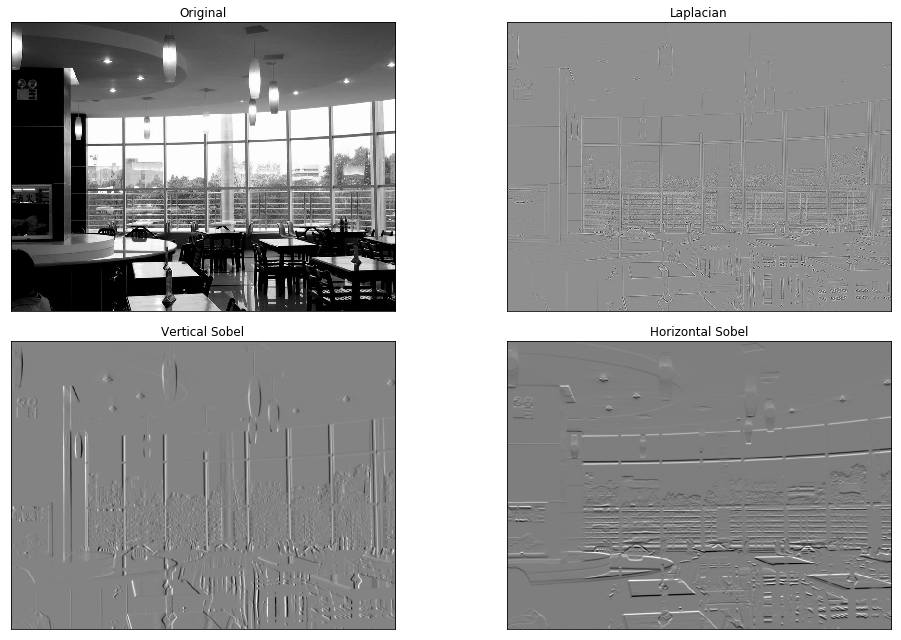

In [29]:
img = plt.imread('diningroom.jpg')
img = img.mean(axis=2) #B&W

plt.figure(figsize=(15,9))

#Gradient filter
laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

titles = ['Original', 'Laplacian', 'Vertical Sobel', 'Horizontal Sobel']
for ind, picture in enumerate([img, laplacian, sobelx, sobely]):
    plt.subplot(2,2,ind+1)
    plt.imshow(picture, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(titles[ind])
plt.tight_layout()
plt.show()


&emsp; After applying the necessary preprocessing techniques, the 12 features of each localized image which I have captured are the following:
1. **Red proportion:** Sum of the red pixel channel, divided by the sum of all pixels in the image.
2. **Green proportion:** Sum of the green pixel channel, divided by the sum of all pixels in the image.
3. **Blue proportion:** Sum of the blue pixel channel, divided by the sum of all pixels in the image (notice that Red+Green+Blue=1.0 for each individual localized image). 
4. **Brightness:** The naive calculation of brightness would be to just take the mean pixel value of the grayscaled image. However, the colors red, green, and blue correspond to different brightnesses (a fully red image would be perceived as more bright than a fully blue image). Thus, we use the mean Luma value, a formula borrowed from video processing, to calculate the brightness of the image. The formula for luma is the following: $$Y=0.2126R+0.7152G+0.0722B$$
The mean value of the 2D array Y is calculated to give us the brightness. <br><br> <br>
After the color proportion and brightness features are extracted, the image is converted to grayscale for the calculation of the remaining features. <br> <br> <br>
5. **Contrast:** Contrast has a number of different definitions, each advantageous in different situations. In our case, since the images are so large, and therefore have high variance between pixel values, I have chosen to use the root mean square (RMS) contrast, given in the formula below:
$$\sqrt{\frac{1}{M N}\sum_{i=0}^{N-1}\sum_{j=0}^{M - 1}(I_{ij} - \bar{I})^2},$$
where intensities ${\displaystyle I_{ij}} I_{{ij}}$ are the ${\displaystyle i}$-th and ${\displaystyle j}$-th element of the two-dimensional image of size ${\displaystyle M}$ by ${\displaystyle N}$. ${\displaystyle {\bar {I}}}$ is the average intensity of all pixel values in the image.
6. **Horizontal Contrast:** This is the RMS contrast of the horizontal image, filtered using the horizontal Sobel edge detector.
7. **Vertical Contrast:** This is the RMS contrast of the vertical image, filtered using the horizontal Sobel edge detector.
8. **Focus measure:** Focus measure also has a variety of different definitions [2], the majority being based on either pixel statistics, autocorrelation of pixels, data compression, or value gradients. For this study, we use the definition of the variance of the Laplacian image (see above). This is a value gradient focus measure: the Laplacian operator leaves the image with only strong edges, so the more strong edges the image has, the more in-focus it is likely to be.
9. **Horizontal Focus Measure:** same as (8), on horizontally filtered Sobel edge detector.
10. **Vertical Focus Measure:** Sam as (8), on vertically filtered Sobel edge detector.
11. **X location:** The X-coordinate of the eye fixation. This value is between 0 and 800, binned into one of the 768 localized images --- thus the X-coordinate is binned into one of 32 potential locations (800 pixels / 25 pixels per localized image).
12. **Y location:** The Y-coordinate of the eye fixation. This value is between 0 and 600, binned into one of the 24 different localized image y-coordinates.  <br> <br>

13. **Fixation (label):** The fixation count increments for each eye fixation which falls in the localized image. Thus, the 120,468 total recorded eye fixations were distributed among the localized images. Some images had as many as 1,232 individual fixations, or as few as 0.

These features were saved in a CSV file 15 columns wide (including all features, and 2 identification columns) and 24,576 rows long. 5 randomly sampled rows are shown below. Notice that the features have not yet been normalized, so that we can more intuitively understand the numbers. When we input these features into machine learning models to try to predict eye fixations, these columns will be normalized.

In [34]:
df_full = pd.read_csv('FULL_fixation_report.csv')
print (df_full.sample(5))

                              picture     short_picture       Red     Green  \
14797  volleyball_outdoor_500_525.jpg        volleyball  0.439727  0.465938   
11695               desert_125_50.jpg            desert  0.268329  0.323048   
13277               closet_300_25.jpg            closet  0.515952  0.305005   
7169               ocean2_200_325.jpg            ocean2  0.211328  0.343163   
5120     basketballcourt5_225_150.jpg  basketballcourt5  0.351815  0.377425   

           Blue  Brightness   Contrast  HorizContrast  VertContrast  \
14797  0.094336   98.473318  17.540146     502.090008    696.157027   
11695  0.408624  202.598181   3.784553     109.199103     64.286438   
13277  0.179043   64.920531  34.864999     775.678470     85.994276   
7169   0.445509  104.781542  32.315085    1814.590810    588.644880   
5120   0.270760   73.435808  17.141964     591.598799    640.095251   

                FM       HorizFM        VertFM    X    Y  Fixation  
14797  2891.722353  7.491918e

# 4. Analysis

# 5. Conclusion

# 6. Sources

1. http://www.sr-research.com/ <br>
2. Pertuz, S., Puig, D., and Garcia, M. "Analysis of focus measure operators for shape-from-focus." _Pattern Recognition_, 2013. <br>
3. Szeliski, Richard. *"Computer Vision: Algorithms and Applications"* Springer, 2010. Draft.
4. Hubel, D., and Wiesel, T. "The period of susceptibility to the physiological effects of unilateral eye closure in kittens." *The Journal of Physiology"* 206 (2). 1970. <br>